# AlexNet代码实现

鉴于原论文中使用的数据集过于庞大，分类过多，目前手头的设备运行是在过于缓慢，折中考虑尝试使用MNIST的数据集实现AlexNet

In [1]:
import torch, torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
%matplotlib inline
import copy

In [2]:
# 超参数设置
EPOCH = 10
BATCH_SIZE = 64
LR = 0.01

In [3]:
transform = transforms.ToTensor()

## 数据集

通过torchvision下载数据集

In [4]:
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=False, transform=transform)
testset = torchvision.datasets.MNIST(root='../data', train=True, transform=transform)

C:\Users\Administrator\AppData\Roaming\Python\Python36\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

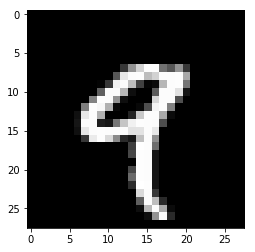

In [6]:
plt.imshow(trainset[4][0][0], cmap='gray')

In [7]:
trainset[0][0].shape

torch.Size([1, 28, 28])

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## AlexNet

In [9]:
class AlexNet(nn.Module):
    def __init__(self,width_mult=1):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), # 32*28*28
            nn.MaxPool2d(kernel_size=2, stride=2), # 32*14*14
            nn.ReLU(inplace=True),
            )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 64*14*14
            nn.MaxPool2d(kernel_size=2, stride=2), # 64*7*7
            nn.ReLU(inplace=True),
            )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 128*7*7
            )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # 256*7*7
            )
 
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # 256*7*7
            nn.MaxPool2d(kernel_size=3, stride=2), # 256*3*3
            nn.ReLU(inplace=True),
            )
        self.fc1 = nn.Linear(256*3*3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(-1, 256*3*3)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [10]:
EPOCH = 5
BATCH_SIZE = 128
LR = 0.01

In [11]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cpu()
        x = net(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total

In [12]:
net = AlexNet().to(device)

In [13]:
# alexnet训练
def train():
    # 定义损失函数为交叉熵损失，优化方法为SGD
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)
    max_accuracy=0
    accuracies=[]
    for epoch in range(EPOCH):
        for i, (images,labels) in enumerate(trainloader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss_item = loss.item()
            loss.backward()
            optimizer.step()

        accuracy = float(validate(criterion, testloader))
        accuracies.append(accuracy)
        print("Epoch %d accuracy: %f loss: %f" % (epoch, accuracy, loss_item))
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(criterion)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return best_model

In [14]:
alexnet = train()

C:\Users\Administrator\.conda\envs\python3.6env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0 accuracy: 97.563332 loss: 0.181040
Saving Best Model with Accuracy:  97.5633316040039
Epoch: 1 Accuracy : 97.5633316040039 %
